# Cohort Analysis

This notebook performs a simple demonstration of the cohort analysis tool used by online marketers to understand the spending trends and habits of their customers.   

The dataset contains actual anonymized customer transactions from an online retailer, and can be found in the [UCI ML Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/00352/)

Additional databases from UCI can be accessed [here](https://archive.ics.uci.edu/ml/machine-learning-databases/)

#### 1.1. Loading data sets and packages

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


dateCols = ['InvoiceDate']
online = pd.read_csv('online.csv', parse_dates = dateCols)

In [3]:
online.head(3)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom


#### 1.2 Assign acquisition month cohort

In [4]:
def get_month(x): return dt.datetime(x.year, x.month, 1)

# Add a column called InvoiceMonth
online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month)

# Groupy Invoice Month by Customer ID
grouping = online.groupby('CustomerID')['InvoiceMonth']

# Add a column called CohortMonth, with minimum value being starting month of the cohort
online['CohortMonth'] = grouping.transform('min')

# review changes to online dataframe
online.head(3)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01


#### 1.3 Extract integer values from data
Define function to extract year, month and day integer values.

In [5]:
def get_date_int(df, column): 
    year = df[column].dt.year 
    month = df[column].dt.month 
    day = df[column].dt.day 
    return year, month, day 

#### 1.4 Adding cohort index column

In [6]:
# to get years_diff and months_diff

invoice_year, invoice_month, _ = get_date_int(online, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(online, 'CohortMonth')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

# CohortIndex in months; +1 for first month inclusive
online['CohortIndex'] = years_diff * 12 + months_diff + 1

online.head(3)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,7
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,3
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,1


#### 1.5 Create table of CohortCounts

In [7]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

# Sort CustomerID by CohortMonth
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

# reset the index cohort_data, then apply pivot method
cohort_data = cohort_data.reset_index()

# apply pivot method
cohort_counts = cohort_data.pivot(index = 'CohortMonth',
                                 columns = 'CohortIndex',
                                 values = 'CustomerID')

print(cohort_counts)

CohortIndex     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2010-12-01   716.0  246.0  221.0  251.0  245.0  285.0  249.0  236.0  240.0   
2011-01-01   332.0   69.0   82.0   81.0  110.0   90.0   82.0   86.0  104.0   
2011-02-01   316.0   58.0   57.0   83.0   85.0   74.0   80.0   83.0   86.0   
2011-03-01   388.0   63.0  100.0   76.0   83.0   67.0   98.0   85.0  107.0   
2011-04-01   255.0   49.0   52.0   49.0   47.0   52.0   56.0   59.0   17.0   
2011-05-01   249.0   40.0   43.0   36.0   52.0   58.0   61.0   22.0    NaN   
2011-06-01   207.0   33.0   26.0   41.0   49.0   62.0   19.0    NaN    NaN   
2011-07-01   173.0   28.0   31.0   38.0   44.0   17.0    NaN    NaN    NaN   
2011-08-01   139.0   30.0   28.0   35.0   14.0    NaN    NaN    NaN    NaN   
2011-09-01   279.0   56.0   78.0   34.0    NaN    NaN    NaN    NaN    NaN   
2011-10-01   318.0   67.0   30.0    NaN    NaN    NaN    NaN    

#### 1.6 Calculate Retention rate


In [8]:
# take the first column as cohort size
cohort_sizes = cohort_counts.iloc[:,0]

# Divide all values in chort_counts by cohort_sizes
retention = cohort_counts.divide(cohort_sizes, axis = 0)

# Convert retention ratio to percentage
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,34.4,30.9,35.1,34.2,39.8,34.8,33.0,33.5,37.0,35.5,48.6,24.0
2011-01-01,100.0,20.8,24.7,24.4,33.1,27.1,24.7,25.9,31.3,30.7,37.3,13.6,NaN
2011-02-01,100.0,18.4,18.0,26.3,26.9,23.4,25.3,26.3,27.2,30.1,8.9,NaN,NaN
2011-03-01,100.0,16.2,25.8,19.6,21.4,17.3,25.3,21.9,27.6,9.8,NaN,NaN,NaN
2011-04-01,100.0,19.2,20.4,19.2,18.4,20.4,22.0,23.1,6.7,NaN,NaN,NaN,NaN
2011-05-01,100.0,16.1,17.3,14.5,20.9,23.3,24.5,8.8,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,15.9,12.6,19.8,23.7,30.0,9.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,16.2,17.9,22.0,25.4,9.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,21.6,20.1,25.2,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 1.7 Average Quantity bought by cohort

In [12]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

# Get the mean for each cohort
cohort_data = grouping['Quantity'].mean()

# Pushes CohortMonth to the right so that it is no longer an index
cohort_data = cohort_data.reset_index()

cohort_data

,CohortMonth,CohortIndex,Quantity
0,2010-12-01,1,11.111588
1,2010-12-01,2,12.260241
2,2010-12-01,3,12.152314
3,2010-12-01,4,13.228676
4,2010-12-01,5,13.669839
5,2010-12-01,6,11.288630
6,2010-12-01,7,10.620746
7,2010-12-01,8,12.783798
8,2010-12-01,9,13.207415
9,2010-12-01,10,12.985885


In [13]:
average_quantity = cohort_data.pivot(index = 'CohortMonth',
                                    columns = 'CohortIndex',
                                    values = 'Quantity')

# Output rounded to 1 decimal place
average_quantity.round(1)


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.1,12.3,12.2,13.2,13.7,11.3,10.6,12.8,13.2,13.0,14.5,10.9,13.7
2011-01-01,10.9,10.8,10.0,10.1,14.3,13.2,17.4,16.4,18.7,10.2,10.7,13.2,NaN
2011-02-01,12.1,14.3,10.6,11.5,17.5,12.2,17.3,13.2,13.4,15.9,14.3,NaN,NaN
2011-03-01,9.6,14.2,13.0,10.2,16.1,12.7,11.6,11.5,9.0,9.6,NaN,NaN,NaN
2011-04-01,9.9,11.1,12.4,11.5,11.4,7.7,10.4,9.4,6.6,NaN,NaN,NaN,NaN
2011-05-01,14.1,9.6,15.3,11.6,11.9,8.5,9.8,7.3,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.6,16.1,18.1,11.2,12.4,7.2,9.7,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,10.9,16.4,5.6,10.1,6.2,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,10.5,7.4,5.5,5.7,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 1.8 Average Price of merchandise bought by cohort

In [14]:
# Create a groupby object (placeholder grouping matrix) sorted by monthly cohort, then cohort index as a sublist
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

# Compute cohort_data column (in this case: average unit price)
cohort_data = grouping['UnitPrice'].mean()

# Reset index of the table, so that CohortMonth is no longer an index
cohort_data = cohort_data.reset_index()

# Pivot it
average_price = cohort_data.pivot(index = 'CohortMonth',
                                 columns = 'CohortIndex',
                                 values = 'UnitPrice')

# rounded to 1 decimal place
print(average_price.round(1))

CohortIndex   1    2    3    4    5    6    7    8    9    10   11   12   13
CohortMonth                                                                 
2010-12-01   3.0  3.0  3.0  2.8  2.7  6.9  2.8  3.0  2.7  2.7  3.0  2.8  2.6
2011-01-01   3.2  3.1  3.0  3.0  3.1  3.0  3.0  2.5  2.7  2.9  2.6  2.0  NaN
2011-02-01   3.1  4.0  3.3  2.9  3.3  2.9  2.8  2.7  2.9  2.7  3.1  NaN  NaN
2011-03-01   3.5  3.6  3.5  2.8  2.7  2.5  2.7  2.9  2.5  2.4  NaN  NaN  NaN
2011-04-01   3.3  4.4  3.4  2.6  2.8  2.8  2.8  2.6  2.6  NaN  NaN  NaN  NaN
2011-05-01   3.1  2.8  2.5  2.7  2.5  2.3  2.7  2.3  NaN  NaN  NaN  NaN  NaN
2011-06-01   2.8  2.4  2.7  3.1  2.5  2.4  2.5  NaN  NaN  NaN  NaN  NaN  NaN
2011-07-01   3.2  3.1  3.4  2.5  2.4  2.3  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-08-01   2.9  3.7  5.4  6.9  4.2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-09-01   2.9  3.1  3.0  2.6  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-10-01   2.9  2.7  2.5  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

#### 1.9 Build the heatmap

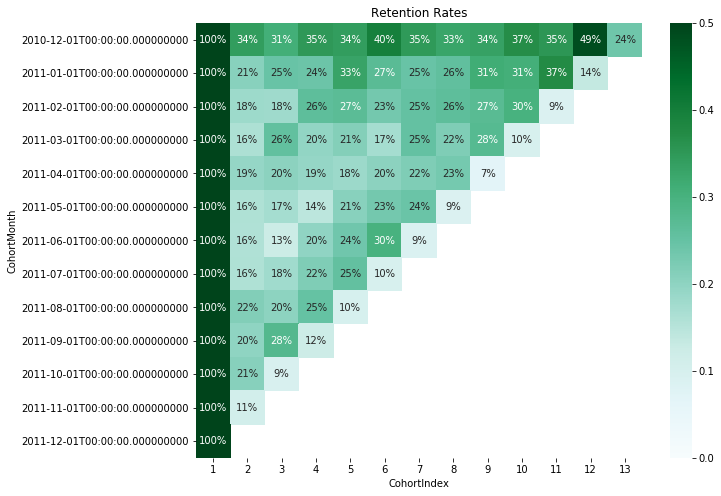

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot figure, size 10 by 8 inches
plt.figure(figsize=(10,8))

plt.title('Retention Rates')

sns.heatmap(data = retention,
           annot = True,
           fmt = '.0%',
           vmin = 0.0,
           vmax = 0.5,
           cmap = 'BuGn')

plt.show()

# fmt = String formatting code to use. '.0%' shows the % to 1 decimal place
# vmin and vmax - to set lightest and darkest shades of green, outliers won't get any darker or lighter
# cmap = 'BuGn' - set colour palette to green.  ColorBrewer color specifications and 
# designs developed by Cynthia Brewer: https://gist.github.com/endolith/2719900